In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import json

In [2]:
import sys
sys.path.append('/private/home/kharitonov/work/EGG/')

In [3]:
from pylab import rcParams
plt.close('all')
rcParams['figure.figsize'] = 8.0, 5.5

font_size = 20
plt.rcParams.update({'font.size': font_size, 'axes.labelsize': font_size, 'xtick.labelsize': font_size,
                    'legend.fontsize': 16,
                    'legend.handlelength': 2})


In [4]:
from egg.zoo.language_bottleneck.mnist_adv.archs import Sender, Receiver
from egg.zoo.language_bottleneck.relaxed_channel import AlwaysRelaxedWrapper
from egg.zoo.language_bottleneck.mnist_classification.data import DoubleMnist

import egg.core as core

def diff_loss_symbol(_sender_input, _message, _receiver_input, receiver_output, labels):
    loss = F.nll_loss(receiver_output, labels, reduction='none').mean()
    acc = (receiver_output.argmax(dim=1) == labels).float().mean()
    return loss, {'acc': acc}


class Predictor(nn.Module):
    def __init__(self, sender, receiver):
        super().__init__()
        self.sender = sender
        self.receiver = receiver
        
    def forward(self, x):
        message = self.sender(x)
        log_prob = self.receiver(message, None)
        return log_prob

In [5]:
def load_sender_receiver(path, header):
    n_classes = 10
    vocab_size = 1024
    temperature = header['temperature']

    mode = None
    receiver = Receiver(vocab_size=vocab_size, n_classes=n_classes)
    sender = Sender(vocab_size=vocab_size, 
                    linear_channel=header['linear_channel'] == 1,
                    softmax_channel=header['softmax_non_linearity'] == 1)
        
    if header['softmax_non_linearity'] == 0 and header['linear_channel'] == 0:
        sender = AlwaysRelaxedWrapper(sender, temperature=temperature)
        mode = f'relaxed, {temperature}'
    elif header['softmax_non_linearity'] == 0 and header['linear_channel'] == 1:
        mode = 'linear'
    elif header['softmax_non_linearity'] == 1 and header['linear_channel'] == 0:
        mode = f'softmax, {temperature}'
    else:
        assert False

    
    checkpoint = torch.load(path)
    game = core.SymbolGameGS(sender, receiver, None)
    game.load_state_dict(checkpoint.model_state_dict)
    
    return sender, receiver, mode


In [6]:
# a bit of an ugly hack
def namespace2dict(s):
    def device(type):
        return str(type)
    Namespace = dict
    return eval(s)

In [22]:
transform = transforms.ToTensor()
test_dataset = datasets.MNIST('/private/home/kharitonov/work/evil-playground/data', train=False, download=False,
                   transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)
n_classes = 10
label_mapping = torch.LongTensor([x % n_classes for x in range(100)])
test_loader = DoubleMnist(test_loader, label_mapping)
                                              
core.init(params=[])


predictors = {}

paths = [
    '/private/home/kharitonov/nest/mnist_adv/2020_06_16_13_11_44/'
]

for p in paths:
    path = pathlib.Path(p)

    for d in path.glob('./*.out'):
        
        with open(d, 'r') as f:
            l = f.readline()
            assert 'job_id=' in l
            start = l.find('job_id=')
            l = l[start + 7:]
            end = l.find(' ')
            subfolder = l[:end-1]
            
            for _ in range(2): f.readline()
                
            header = namespace2dict(f.readline())
            parsed = None
            while True:
                l = f.readline()
                if not l: break
                if l.startswith('submitit'): continue
                    
                l = json.loads(l)
                if l['mode'] == 'test':
                    parsed = l
            if parsed is None or parsed['acc'] < 0.98:
                continue
                

        model_path = header['checkpoint_dir'] + '/' + subfolder + '/final.tar'

        sender, receiver, mode = load_sender_receiver(model_path, header)
        if mode not in predictors: predictors[mode] = []
        predictors[mode].append(Predictor(sender, receiver))

In [24]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [25]:
def test(model, device, test_loader, epsilon):

    double = True
    model = model.cuda().eval()
    
    if double: model.double()
        
    correct = 0.0
    adv_examples = []
    positive_examples = []

    n_examples = 0.0
    for data, target in test_loader:
        n_examples += data.size(0)
        
        data, target = data.to(device), target.to(device)
        if double: 
            data = data.double()
            
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        loss = F.nll_loss(output, target)

        model.zero_grad()
        
        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.argmax(dim=1) # get the index of the max log-probability
        
        correct += (final_pred == target).sum().item()
    final_acc = correct / n_examples
    return final_acc, adv_examples, positive_examples

In [11]:
epsilons = [0, 0.1, 0.125, 0.15, 0.175, 0.2,  0.225, 0.25]

device = "cuda"

per_key = {}

for key, models in predictors.items():
    for model in models:
        accuracies = []

        for eps in epsilons:
            acc, _ex1, _ex2 = test(model, device, test_loader, eps)
            accuracies.append(acc)
    
        if key not in per_key: per_key[key] = []
        per_key[key].append(accuracies)

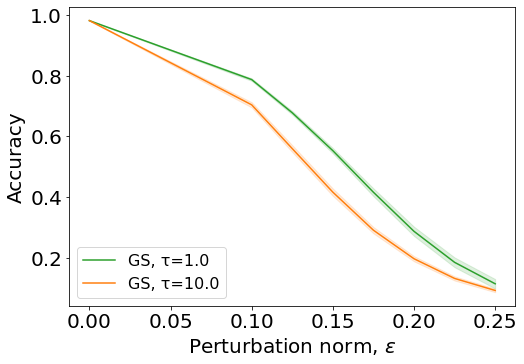

In [31]:
def plot(filename, data, xs, loc):
    for name in ['relaxed, 1.0', 'relaxed, 10.0']:
        acc = [np.mean(x) for x in zip(*data[name])]
        acc = np.array(acc)
        std = [np.std(x) / np.sqrt(len(x))  for x in zip(*data[name])]
        std = np.array(std)

        color = {
            'relaxed, 1.0': '#2ca02c',
            'relaxed, 10.0': '#ff7f0e',
            'softmax': 'black',
            'linear': 'olive'
        }[name]
        
        names = {
            'relaxed, 1.0': 'GS, τ=1.0',
            'relaxed, 10.0': 'GS, τ=10.0',
            'softmax, 1.0': 'SM, τ=1.0',
            'linear': 'Linear'
        }
        if name not in names: continue
        name = names[name]
            
        p = plt.plot(xs, acc, linestyle='-',  label=name, color=color)
        plt.fill_between(xs, acc-std, acc+std, alpha=0.15, color=p[0].get_color())

    plt.legend(loc=loc)
    plt.ylabel("Accuracy")
    plt.xlabel("Perturbation norm, $\epsilon$")
    plt.savefig(filename)

    plt.show()
plot('adversarial_by_t.pdf', per_key, epsilons, 'lower left')

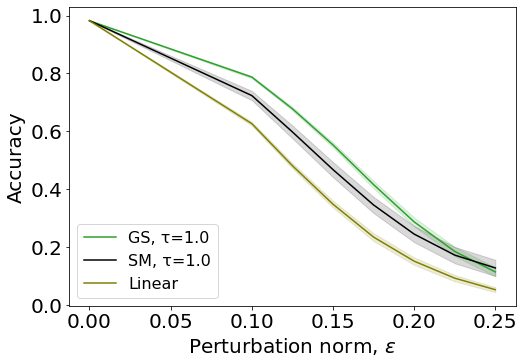

In [32]:
def plot(filename, data, xs, loc):
    for name in ['relaxed, 1.0', 'softmax, 1.0', 'linear']:
        #if name in ['softmax, 10.0']: continue
            
        acc = [np.mean(x) for x in zip(*data[name])]
        acc = np.array(acc)
        std = [np.std(x) / np.sqrt(len(x))  for x in zip(*data[name])]
        std = np.array(std)

        color = {
            'relaxed, 1.0': '#2ca02c',
            'relaxed, 10.0': '#ff7f0e',
            'softmax, 1.0': 'black',
            'softmax, 10.0': 'silver',
            'linear': 'olive'
        }[name]
        
        names = {
            'relaxed, 1.0': 'GS, τ=1.0',
            'softmax, 1.0': 'SM, τ=1.0',
            'linear': 'Linear'
        }
        if name not in names: continue
        name = names[name]
               
        p = plt.plot(xs, acc, linestyle='-',  label=name, color=color)
        plt.fill_between(xs, acc-std, acc+std, alpha=0.15, color=p[0].get_color())

    plt.legend(loc=loc)
    plt.ylabel("Accuracy")
    plt.xlabel("Perturbation norm, $\epsilon$")
    plt.savefig(filename)

    plt.show()
plot('adversarial_vs_baselines.pdf', per_key, epsilons, 'lower left')